# Navigation 

---
A standalone notebook for training the DQN Agent on Banana collector task.

You do not required to install the Unity ML-Agents environment. In oder to install the environments and right dependencies follow the instruction in:

* [Udacity Deep Reinforcement Learning  repository](https://github.com/udacity/deep-reinforcement-learning#dependencies)
* [Udacity Deep RL Navigation 1 Project](https://github.com/udacity/deep-reinforcement-learning/tree/master/p1_navigation#getting-started)





In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


In [2]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import math
import numpy as np
from collections import namedtuple, deque
from matplotlib import pyplot as plt 
from unityagents import UnityEnvironment

%matplotlib inline 


In [3]:
class PrioritizedReplayBuffer(object):
    """ Prioritized experience buffer implementation """
    def __init__(self, buffer_size, prob_alpha,):
        """
         :param: buffer_size (int): maximum size of buffer 
         :param: prob_alpha (int): prioritization exponent 
        """
        self.prob_alpha = prob_alpha
        self.buffer = deque(maxlen=buffer_size)  
        self.priorities = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

        
    def __len__(self):
        return len(self.buffer)

    def add(self, sample):
        """ 
          Add a new experience to memory.
           :param sample: a tuple of (state, action, reward, next_state, done)
        """
        self.buffer.append(self.experience(*sample))
        try:
            max_prio = np.max(self.priorities) if len(self.priorities)>0 else 1.0      
        except ValueError:
            #print(self.priorities)
            raise
        self.priorities.append(max_prio) 

    def sample(self, batch_size, beta=0.4):    
        """ 
        Randomly sample a batch of experiences from memory.
        :param batch_size: number of samples in each batch
        """
        if self.__len__() ==0:
            return None
        
        probs = np.asarray(self.priorities) ** self.prob_alpha
        probs /= probs.sum()
        indices = np.random.choice(self.__len__(), replace=False, 
                                   size=min(batch_size, self.__len__()), p=probs)
        samples = [self.buffer[idx] for idx in indices]
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32).reshape((len(weights),1))

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio


class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size):
        """Initialize a ReplayBuffer object.

        :param: buffer_size (int): maximum size of buffer            
        """               
        self.buffer = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.buffer)
    
    def add(self, sample):
        """
        Add a new experience to memory.
           :param sample: a tuple of (state, action, reward, next_state, done)
        """
        self.buffer.append(self.experience(*sample))
    
    def sample(self, batch_size):
        """ 
        Randomly sample a batch of experiences from memory.
        :param batch_size: number of samples in each batch
        """
        if self.__len__() ==0:
            return None
        indices = np.random.choice(self.__len__(), replace=False, size=min(batch_size,self.__len__()))
        return [self.buffer[idx] for idx in indices]
        
   

def convert_batch_to_tensor(experiences, batch_weights, device="cpu"):
    """
    Receieves batch of experience and convert it to torch tensor
   :param experiences: list oftuple of (s, a, r, s', done) tuples 
   :param batch_weights: list priority weights per experiens, the value is None for regular buffer
   :param device: device type for torch tensor
    """
    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).long().to(device)    
    batch_weights = torch.tensor(batch_weights).to(device).float()
    return states, actions, rewards, next_states, dones, batch_weights 



In [4]:
#######
class QNetworkWithBatchNorm(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetworkWithBatchNorm, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc_features =  nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.BatchNorm1d(fc1_units),
            nn.ReLU(),
            nn.Linear(fc1_units, fc2_units),
            nn.BatchNorm1d(fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, fc2_units),
            nn.BatchNorm1d(fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, fc2_units),
            nn.BatchNorm1d(fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, action_size))
        
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        return self.fc_features(state)

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc_features =  nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.ReLU(),
            nn.Linear(fc1_units, fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, action_size))
       
    
    def forward(self, state):
        """Build a network that maps state -> action values."""      
        return self.fc_features(state)
    
    
class DuelingNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(DuelingNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc_features = nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.BatchNorm1d(fc1_units),
            nn.ReLU(),
            nn.Linear(fc1_units, fc2_units),
            nn.BatchNorm1d(fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, fc2_units),
            nn.BatchNorm1d(fc2_units),
            nn.ReLU())    
        self.fc_adv = nn.Sequential(
            nn.Linear(fc2_units, fc2_units),
            nn.BatchNorm1d(fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, action_size))
        self.fc_val = nn.Sequential(
            nn.Linear(fc2_units, fc2_units),
            nn.BatchNorm1d(fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, 1))    

    def forward(self, x):
        x = self.fc_features(x)
        val = self.fc_val(x)
        adv = self.fc_adv(x)
        return val + adv - adv.mean()
    
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, **kwargs): 
        """
        initialize an Agent object.
        
        :param state_size (int): dimension of each state
        :param: action_size (int): dimension of each action
        :param: seed (int): random seed
        """
        #---- general parameters --------#
        self.seed = kwargs.get("seed",47)
        np.random.seed(self.seed)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.agent_description = kwargs.get("agent_description", "vanilla DQN")
        self.agent_name = kwargs.get("agent_name", "v_dqn")

        
        #---- q network parameters ------#
        self.dueling_dqn = kwargs.get("dueling_dqn",False)
        self.with_batch_norm = kwargs.get("with_batch_norm", False)
        self.state_size = kwargs.get("state_size", 37)
        self.action_size = kwargs.get("action_size", 4)     
        self.load_model = kwargs.get("load_model", False)
        
        #---- replay buffer parameters --#
        self.use_per = kwargs.get("use_per", False)
        self.buffer_size = int(kwargs.get("buffer_size", 1e4)) 
        self.combined_reply_buffer = kwargs.get("combined_reply_buffer", False)
        self.alpha= kwargs.get("alpha",0.7)

        #---- DQN training parameters ---#                                
        self.gamma = kwargs.get("gamma",0.99)
        self.learning_rate = kwargs.get("learning_rate",0.00025)
        self.tau = kwargs.get("tau",0.001)
        self.gradient_clip_norm = kwargs.get("gradient_clip_norm",5.0)
        self.update_every =  kwargs.get("update_every",1)        
        self.exploration_steps = kwargs.get("exploration_steps",1000)
        self.target_network_update_freq = kwargs.get("target_network_update_freq",4)
        self.batch_size = kwargs.get("batch_size",32)
        self.use_soft_update = kwargs.get("use_soft_update",True)                                    
        self.double_dqn = kwargs.get("double_dqn",False)
        
        #---- build q network & replay memory -#
        
        # Replay memory
        if self.use_per:
            self.memory = PrioritizedReplayBuffer(self.buffer_size, self.alpha)
        else:    
            self.memory = ReplayBuffer(self.buffer_size,)
        
        if not self.dueling_dqn:
            if self.with_batch_norm:
                self.qnetwork_online = QNetworkWithBatchNorm(self.state_size, 
                                                             self.action_size,
                                                             self.seed).to(self.device)
                self.qnetwork_target = QNetworkWithBatchNorm(self.state_size, 
                                                             self.action_size,
                                                             self.seed).to(self.device)
            else:
                self.qnetwork_online = QNetwork(self.state_size,
                                                self.action_size,
                                                self.seed).to(self.device)
                self.qnetwork_target = QNetwork(self.state_size,
                                                self.action_size,
                                                self.seed).to(self.device)
        else:
            self.qnetwork_online = DuelingNetwork(self.state_size,
                                                  self.action_size,
                                                  self.seed).to(self.device)
            self.qnetwork_target = DuelingNetwork(self.state_size,
                                                  self.action_size,
                                                  self.seed).to(self.device)
        
        self.optimizer = optim.Adam(self.qnetwork_online.parameters(), lr=self.learning_rate)
        
        if self.load_model:
            self.qnetwork_online.load_state_dict(kwargs.get("model_state_dict"),None)
            self.qnetwork_target.load_state_dict(kwargs.get("model_state_dict"),None)
            self.optimizer.load_state_dict(kwargs.get("optimizer_state_dict"),None)
       
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done, beta):
        """
        apply one step of learning and add the new sample to the memory
        :param state:
        :param action:
        :param reward:
        :param next_state:
        :param done:
        :param beta: important sampling exponent for calculating weights of prioritized samples
        """
        self.t_step +=1
        # Save experience in replay memory        
        self.memory.add((state, action, reward, next_state, done))
        # Learn every UPDATE_EVERY time steps.
        if self.t_step > self.exploration_steps :
            # If enough samples are available in memory, get random subset and learn            
            if self.use_per:
                experiences, batch_indices, batch_weights = self.memory.sample(self.batch_size, beta)
            else:
                experiences = self.memory.sample(self.batch_size)
                if self.combined_reply_buffer:
                    experiences.append(self.memory.experience(state, action, reward, next_state, done )) 
                batch_indices = None
                batch_weights = np.ones((len(experiences), 1))
            if self.t_step  %  self.update_every == 0:
                self.learn(experiences, batch_indices, batch_weights)

    def act(self, state, eps=0.1):
        """
        returns actions for given state as per current policy.
        :param: state (array_like): current state
        :param: eps (float): epsilon, for epsilon-greedy action selection
        """  
        # Epsilon-greedy action selection
        if np.random.rand() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0)
            self.qnetwork_online.eval()
            with torch.no_grad():
                action_values = self.qnetwork_online(state.to(self.device))
            self.qnetwork_online.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.choice(self.action_size, replace=False)
        
    def calculate_loss(self, experiences, qnetwork_online, qnetwork_target, gamma, batch_weights, 
                    double_dqn=False, device="cpu"):
        """
        caculated loss given online network and target network
        :param experiences: list oftuple of (s, a, r, s', done) tuples 
        :param: qnetwork_online: behaviore policy netework for online interaction with environment
        :param: qnetwork_target: target policty netwrok calculating expected value
        :param: gamma: discount factor for Belman equation
        :param: batch_weights:  list priority weights per experiens, the value is None for regular buffer
        :param: double_dqn: if doulbe DQN algorithm for calcuting expected value
        :param device: device type for torch tensor
        """

        states, actions, rewards, next_states, dones, batch_weights =\
            convert_batch_to_tensor(experiences, batch_weights, device) 
        state_action_values = qnetwork_online(states).gather(1, actions.squeeze(0)).squeeze(0)
        with torch.no_grad():
            if double_dqn:
                next_state_values = qnetwork_target(next_states).gather(1, torch.argmax(qnetwork_online(next_states),dim=-1).unsqueeze(-1)).squeeze(-1)
            else:             
                next_state_values = qnetwork_target(next_states).max(1)[0]
        next_state_values[dones] = 0.0
        expected_state_action_values = next_state_values.unsqueeze(1).detach() * gamma + rewards
        losses = batch_weights * (state_action_values - expected_state_action_values) ** 2
        return losses.mean(), losses + 1e-6

    def learn(self, experiences, batch_indices, batch_weights):
        """
         update value parameters using given batch of experience tuples.
         
        :param: experiences (list): tuple of (s, a, r, s', done) tuples 
        :param: gamma (float): discount factor
        """                                 
        loss, sample_prios = self.calculate_loss(experiences, self.qnetwork_online, self.qnetwork_target,
                                            self.gamma, batch_weights, self.double_dqn, self.device)
        if self.use_per:
            self.memory.update_priorities(batch_indices, sample_prios.squeeze(1).data.cpu().numpy())
        
        # -------------------- apply gradient -----------------------#
        self.optimizer.zero_grad() 
        loss.backward()
        self.optimizer.step()
        nn.utils.clip_grad_norm_(self.qnetwork_online.parameters(), self.gradient_clip_norm)       
        self.optimizer.step()
        # ------------------- update target network ------------------- #      
        if (self.t_step / self.update_every) %  self.target_network_update_freq == 0:
            if self.use_soft_update:
                """
                soft update model parameters.   θ_target = τ*θ_local + (1 - τ)*θ_target
                """ 
                for target_param, online_param in zip(self.qnetwork_target.parameters(),
                                                      self.qnetwork_online.parameters()):
                    target_param.data.copy_(self.tau * online_param.data + (1.0 - self.tau)*target_param.data)
            else:
                self.qnetwork_target.load_state_dict(self.qnetwork_online.state_dict())


In [5]:
def dqn(
    agent_config,
    eps_start=1.0,
    n_episodes=100,
    eps_end=0.05,
    eps_decay=0.995,
    env=None,
    brain_name=None,
):
    """

    Parameters
    ----------
    agent_config : configuration to build DQN Agent
    eps_start : Epsilon greedy start value
    n_episodes : number of episode
    eps_end : minimum number of epsilon greedy
    eps_decay : factor to decay epsilon greedy
    env : banana environment
    brain_name: brain name of the env object for extracting state information

    Returns
    -------

    """
    
    agent = Agent(**agent_config)
    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start  # initialize epsilon
    BETA_START = 0.5
    frame_idx = 0
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        beta = min(
            1.0, BETA_START + i_episode * (1.0 - BETA_START) / agent.buffer_size
        )
        for t in range(1000): 
            action = agent.act(state, eps)
            env_info = env.step(action)[
                brain_name
            ]  # send the action to the environment
            next_state = env_info.vector_observations[0]  # get the next state
            reward = env_info.rewards[0]  # get the reward
            done = env_info.local_done[0]  # see if episode has finished
            agent.step(state, action, reward, next_state, done, beta)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon
        # rl = max(0.00001, rl*eps) # decrease epsilon
        print(
            "\rEpisode {} \t Average Score: {:.2f}".format(
                i_episode, np.mean(scores_window)
            ),
            end="",
        )
        if i_episode % 100 == 0:
            print("\t eps: {}".format(eps))
        if np.mean(scores_window) > 13.0:
            print(
                "\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}".format(
                    i_episode, np.mean(scores_window)
                )
            )
            checkpoint = {
                "agent_config": agent_config,
                "model_state_dict": agent.qnetwork_online.state_dict(),
                "optimizer_state_dict": agent.optimizer.state_dict(),
                "number_of_episode": i_episode,
                "scores":scores,
            }
            torch.save(
                checkpoint, "checkpoint_{}.pth".format(agent_config["agent_name"])
            )
            break
    return scores


In [6]:
env_file_path="/data/Banana_Linux_NoVis/Banana.x86_64"
banana_env = UnityEnvironment(file_name=env_file_path)
banana_brain = banana_env.brain_names[0]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [7]:
agent_config={"agent_name":"v_dqn",
              "agetn_desription":"vanilla dqn with simple FC q network",
              "gamma":0.99,              
              "learning_rate":0.00025,
              "use_per":False,                       
              "combined_reply_buffer":False,                       
              "update_every":1,
              "target_network_update_freq":4,
              "buffer_size":int(1e5),
              "with_batch_norm":False,
              "double_dqn":False,                       
              "dueling_dqn":False,}
scores_v_dqn =  dqn(agent_config, eps_start=1.0, n_episodes=1000, env=banana_env, brain_name=banana_brain,)


Episode 100 	 Average Score: 0.62	 eps: 0.6057704364907278
Episode 200 	 Average Score: 3.67	 eps: 0.3669578217261671
Episode 300 	 Average Score: 7.74	 eps: 0.22229219984074702
Episode 400 	 Average Score: 9.64	 eps: 0.1346580429260134
Episode 500 	 Average Score: 12.14	 eps: 0.08157186144027828
Episode 553 	 Average Score: 13.08
Environment solved in 553 episodes!	Average Score: 13.08


In [8]:
agent_config={"agent_name":"v_dqn_w_bn",
              "agetn_desription":"vanilla dqn with batch normalized FC q-network & Simple Replay Buffer",
              "gamma":0.99,              
              "learning_rate":0.00025,
              "use_per":False,                       
              "combined_reply_buffer":False,                       
              "update_every":1,
              "target_network_update_freq":4,
              "buffer_size":int(1e5),
              "with_batch_norm":True,
              "double_dqn":False,                       
              "dueling_dqn":False,}
scores_v_dqn_w_bn = dqn(agent_config, eps_start=1.0, n_episodes=1000, env=banana_env, brain_name=banana_brain,)

Episode 100 	 Average Score: 0.77	 eps: 0.6057704364907278
Episode 200 	 Average Score: 3.84	 eps: 0.3669578217261671
Episode 300 	 Average Score: 7.96	 eps: 0.22229219984074702
Episode 400 	 Average Score: 10.74	 eps: 0.1346580429260134
Episode 493 	 Average Score: 13.03
Environment solved in 493 episodes!	Average Score: 13.03


In [9]:
agent_config={"agent_name":"v_dqn_w_bn_cb",
              "agetn_desription":"vanilla dqn with batch normalized FC q-network & Combined Replay Buffer",
              "gamma":0.99,              
              "learning_rate":0.00025,
              "use_per":False,                       
              "combined_reply_buffer":True,                       
              "update_every":1,
              "target_network_update_freq":4,
              "buffer_size":int(1e5),
              "with_batch_norm":True,
              "double_dqn":False,                       
              "dueling_dqn":False,}
scores_v_dqn_w_bn_cb =  dqn(agent_config, eps_start=1.0, n_episodes=1000, env=banana_env, brain_name=banana_brain,)

Episode 100 	 Average Score: 0.65	 eps: 0.6057704364907278
Episode 200 	 Average Score: 3.37	 eps: 0.3669578217261671
Episode 300 	 Average Score: 6.89	 eps: 0.22229219984074702
Episode 400 	 Average Score: 10.83	 eps: 0.1346580429260134
Episode 462 	 Average Score: 13.03
Environment solved in 462 episodes!	Average Score: 13.03


In [10]:
agent_config={"agent_name":"v_dqn_w_bn_per",
              "agetn_desription":"vanilla dqn with batch normalized FC q-network & Prioritized Replay Buffer",
              "gamma":0.99,              
              "learning_rate":0.00025,
              "use_per":True,                       
              "combined_reply_buffer":False,                       
              "update_every":1,
              "target_network_update_freq":4,
              "buffer_size":int(1e5),
              "with_batch_norm":True,
              "double_dqn":False,                       
              "dueling_dqn":False,}
scores_v_dqn_w_bn_per =  dqn(agent_config, eps_start=1.0, n_episodes=1000, env=banana_env, brain_name=banana_brain,)

Episode 100 	 Average Score: 0.15	 eps: 0.6057704364907278
Episode 200 	 Average Score: 1.41	 eps: 0.3669578217261671
Episode 300 	 Average Score: 3.68	 eps: 0.22229219984074702
Episode 400 	 Average Score: 6.77	 eps: 0.1346580429260134
Episode 500 	 Average Score: 8.87	 eps: 0.08157186144027828
Episode 600 	 Average Score: 10.53	 eps: 0.05
Episode 700 	 Average Score: 11.62	 eps: 0.05
Episode 786 	 Average Score: 13.08
Environment solved in 786 episodes!	Average Score: 13.08


In [11]:
agent_config={"agent_name":"dd_dqn_w_bn_per",
              "agetn_desription":"double dqn with batch normalized FC q-network & Prioritized Replay Buffer",
              "gamma":0.99,              
              "learning_rate":0.00025,
              "use_per":True,                       
              "combined_reply_buffer":False,                       
              "update_every":1,
              "target_network_update_freq":4,
              "buffer_size":int(1e5),
              "with_batch_norm":True,
              "double_dqn":True,                       
              "dueling_dqn":False,}
scores_dd_dqn_w_bn_per =  dqn(agent_config, eps_start=1.0, n_episodes=1000, env=banana_env, brain_name=banana_brain,)

Episode 100 	 Average Score: 0.19	 eps: 0.6057704364907278
Episode 200 	 Average Score: 1.66	 eps: 0.3669578217261671
Episode 300 	 Average Score: 2.69	 eps: 0.22229219984074702
Episode 400 	 Average Score: 5.18	 eps: 0.1346580429260134
Episode 500 	 Average Score: 8.43	 eps: 0.08157186144027828
Episode 600 	 Average Score: 9.03	 eps: 0.05
Episode 700 	 Average Score: 10.82	 eps: 0.05
Episode 800 	 Average Score: 11.85	 eps: 0.05
Episode 889 	 Average Score: 13.02
Environment solved in 889 episodes!	Average Score: 13.02


In [12]:
agent_config={"agent_name":"dd_dqn_w_bn_per_de",
              "agetn_desription":"double dqn with batch normalized duelling q-network & Prioritized Replay Buffer",
              "gamma":0.99,              
              "learning_rate":0.00025,
              "use_per":True,                       
              "combined_reply_buffer":False,                       
              "update_every":1,
              "target_network_update_freq":4,
              "buffer_size":int(1e5),
              "with_batch_norm":True,
              "double_dqn":True,                       
              "dueling_dqn":True,}
scores_dd_dqn_w_bn_per_de =  dqn(agent_config, eps_start=1.0, n_episodes=1000, env=banana_env, brain_name=banana_brain,)

Episode 100 	 Average Score: 0.51	 eps: 0.6057704364907278
Episode 200 	 Average Score: 2.11	 eps: 0.3669578217261671
Episode 300 	 Average Score: 5.28	 eps: 0.22229219984074702
Episode 400 	 Average Score: 8.16	 eps: 0.1346580429260134
Episode 500 	 Average Score: 9.07	 eps: 0.08157186144027828
Episode 600 	 Average Score: 11.86	 eps: 0.05
Episode 636 	 Average Score: 13.07
Environment solved in 636 episodes!	Average Score: 13.07


In [48]:
def plot_scores(scores, title="Scores"):
    fig,ax= plt.subplots(1,1, figsize=(10,5))
    x=range(0,len(scores),100)
    y_mean=np.asarray([np.mean(scores[i:i+100]) for i in range(0,len(scores),100)])
    y_std=np.asarray([np.std(scores[i:i+100]) for i in range(0,len(scores),100)])
    ax.plot(x, y_mean, color='r', )
    ax.fill_between(x, y_mean -y_std, y_mean+y_std)
    ax.axhline(y=13, color='k', linestyle='-')
    ax.set_title(title)
    ax.set_ylabel("Mean & STD scores")
    ax.set_xlabel("episode number")
    ax.set_xlim([0,1000])
    ax.set_xticks(range(0,1000,50))

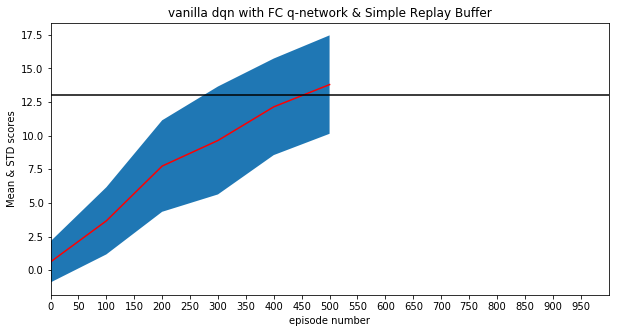

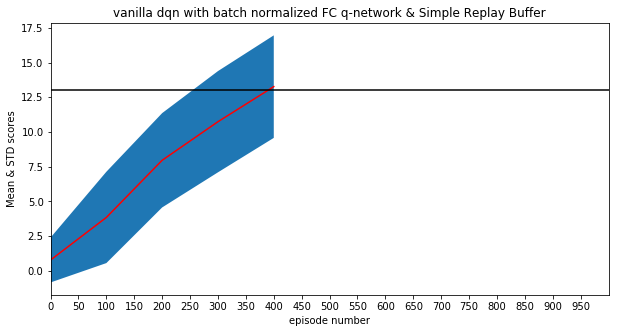

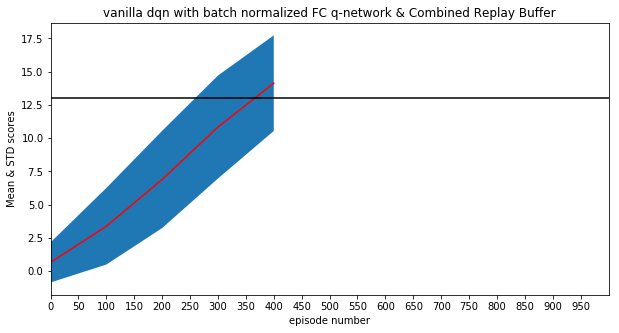

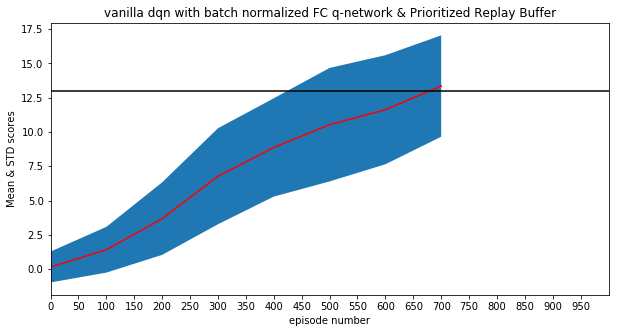

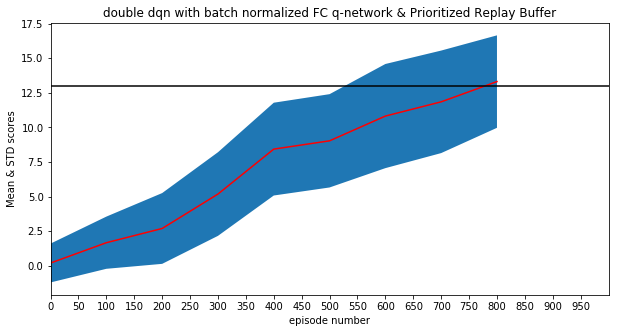

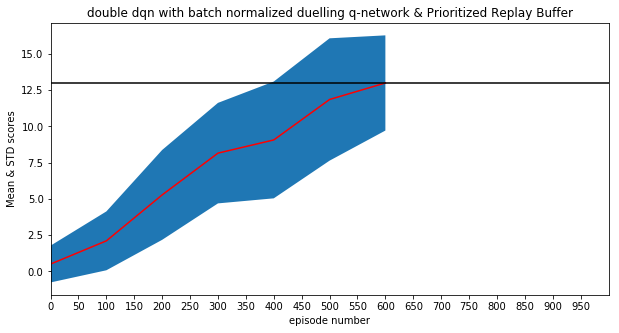

In [49]:
plot_scores(scores_v_dqn, title="vanilla dqn with FC q-network & Simple Replay Buffer")
plot_scores(scores_v_dqn_w_bn, title="vanilla dqn with batch normalized FC q-network & Simple Replay Buffer")
plot_scores(scores_v_dqn_w_bn_cb, title="vanilla dqn with batch normalized FC q-network & Combined Replay Buffer")
plot_scores(scores_v_dqn_w_bn_per , title="vanilla dqn with batch normalized FC q-network & Prioritized Replay Buffer")
plot_scores(scores_dd_dqn_w_bn_per, title="double dqn with batch normalized FC q-network & Prioritized Replay Buffer")
plot_scores(scores_dd_dqn_w_bn_per_de, title="double dqn with batch normalized duelling q-network & Prioritized Replay Buffer")